In [95]:
# For sending GET requests from the API
import requests
# For saving access tokens and for file management when creating and adding to the dataset
import os
# For dealing with json responses we receive from the API
import json
# For displaying the data after
import numpy as np
import pandas as pd
# For saving the response data in CSV format
import csv
# For parsing the dates received from twitter in readable formats
import datetime
import dateutil.parser
import unicodedata
#To add wait time between requests
import time
#Imports timer
import tqdm
#To do Regex
import re
#To do sentiment analysis
from textblob import TextBlob
#To do bot analysis
import botometer

import matplotlib.pyplot as plt 
import seaborn as sns

## Import data from CSV file to a DataFrame

In [62]:
data_df = pd.read_csv('twitter_API_data_raw.csv')

In [63]:
data_df.head(2)

,text,reply_settings,source,id,conversation_id,author_id,public_metrics,in_reply_to_user_id,referenced_tweets,lang,created_at,geo
0,@alqsyy @Mutantduckclub8 RYOGE- The shiba kill...,everyone,Twitter for Android,1559180467781378056,1559090445656866816,1557092549638111233,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1.060756e+18,"[{'type': 'replied_to', 'id': '155909044565686...",en,2022-08-15T14:09:26.000Z,NaN
1,@Amrit45970471 @palletjacker69 Join doge mutan...,everyone,Twitter for Android,1559180445987880963,1559082707078217729,1551828952011997184,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1.355349e+18,"[{'type': 'replied_to', 'id': '155908300539771...",en,2022-08-15T14:09:21.000Z,NaN


## Cleaning up DataFrame

### Adding and removing columns

In [68]:
#Add date and date_hour columns as datetime objects:
data_df['date'] = pd.to_datetime(data_df['created_at']).dt.date
data_df['date_hour'] = pd.to_datetime([str[:-10]+'00:00' for str in data_df['created_at']])


#Add counter columns
find_counts = re.compile(r'\b\d+\b')                                         #Define regex for finding the counts
metrics_list = ['retweet_count', 'reply_count', 'like_count', 'quote_count'] #Define names of the new columns
j=0
for i in metrics_list:
    data_df[i] = [find_counts.findall(i)[j] for i in data_df['public_metrics']]
    j+=1

    
#Drop columns
drop_columns = ['reply_settings', 'source', 'id', 'conversation_id', 'public_metrics', 'in_reply_to_user_id', 'referenced_tweets', 'lang', 'created_at', 'geo']
clean_df = data_df.drop(drop_columns, axis=1)
clean_df.head(2)

,text,author_id,date,date_hour,retweet_count,reply_count,like_count,quote_count
0,@alqsyy @Mutantduckclub8 RYOGE- The shiba kill...,1557092549638111233,2022-08-15,2022-08-15 14:00:00,0,0,0,0
1,@Amrit45970471 @palletjacker69 Join doge mutan...,1551828952011997184,2022-08-15,2022-08-15 14:00:00,0,0,0,0


### Removing columns

### Sample

In [72]:
clean_df.sample(2)

,text,author_id,date,date_hour,retweet_count,reply_count,like_count,quote_count
42308,@JackpotDoge Very hard working team with big p...,1178489459316346880,2022-08-13,2022-08-13 11:00:00,0,0,5,0
106336,#crypto #dogecoin earn 1.3% every day with thi...,1518978189065953281,2022-08-10,2022-08-10 10:00:00,0,0,0,0


### Save cleaned data as CSV for future use

In [73]:
clean_df.to_csv('twitter_API_data_cleaned.csv', index=False) #index=False makes sure that the index is not saved as an extra column

## Some initial plotting

# Sentiment analysis

First we define two functions:
* One that cleans a given tweet for unnecessary stuff, such as mentions etc
* One that uses the TextBlob library's sentiment function to determine a given tweets sentiment

In [74]:
def clean_tweet(tweet):
    '''
    Using RegEx, this function cleans the tweets for unnecessary fluffer
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def get_tweet_sentiment(tweet):
    '''
    Uses textblob to decide sentiment of a parsed tweet
    '''
    # Create TextBlob object
    blob = TextBlob(clean_tweet(tweet))
        
    # Set sentiment
    if blob.sentiment.polarity > 0:
        return 'positive'
    elif blob.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

## Adding a sentiment-column

Using list comprehension we use the above defined functions on each tweet text in clean_df

### OBS: the cell takes around 1-2 minutes to run

In [75]:
clean_df['sentiment'] = [get_tweet_sentiment(tweet) for tweet in tqdm.tqdm(clean_df['text'])]

100%|████████████████████████████████████████████████████████████████████████| 145933/145933 [00:56<00:00, 2591.83it/s]


### Adding sentiment as numerical values (-1, 0, 1)

In [77]:
sentiment_dict = {
  "negative": -1,
  "neutral": 0,
  "positive": 1}

clean_df['numerical'] = [sentiment_dict[i] for i in clean_df['sentiment']]

### Sample

In [78]:
clean_df.sample(2)

,text,author_id,date,date_hour,retweet_count,reply_count,like_count,quote_count,sentiment,numerical
79857,"A $200,000 purchase of PulseDogecoin will rais...",1459234749113851904,2022-08-11,2022-08-11 13:00:00,6,4,20,0,neutral,0
33207,Myths which are believed in tend to become tru...,1488892394548469765,2022-08-13,2022-08-13 21:00:00,0,0,0,1,positive,1


### Saving to CSV for future use

In [80]:
clean_df.to_csv('twitter_API_data_sentiment.csv')

## Descriptive analysis

Data series creation per day

In [139]:
### Number of tweets per day mentioning 'doge'
tweets_per_day = clean_df['text'].groupby(clean_df['date']).count()
tweets_per_hour = clean_df['text'].groupby(clean_df['date_hour']).count()

### Number of tweets mentioning 'doge' in each sentiment category
tweets_by_sentiment = clean_df['text'].groupby(clean_df['sentiment']).count()

### Sum and mean of numerical sentiment value per day (ie. "Sentiment per day/hour")
sum_sentiment_per_day = clean_df['numerical'].groupby(clean_df['date']).sum()
mean_sentiment_per_day = clean_df['numerical'].groupby(clean_df['date']).mean()

sum_sentiment_per_hour = clean_df['numerical'].groupby(clean_df['date_hour']).sum()
mean_sentiment_per_hour = clean_df['numerical'].groupby(clean_df['date_hour']).mean()

#Dataframe with sum and mean per hour
sentiment_per_hour = pd.DataFrame({'Sum': sum_sentiment_per_hour, 'Mean': mean_sentiment_per_hour}).reset_index()

In [140]:
sentiment_per_hour

,date_hour,Sum,Mean
0,2022-08-08 15:00:00,332,0.435696
1,2022-08-08 16:00:00,408,0.378830
2,2022-08-08 17:00:00,430,0.401494
3,2022-08-08 18:00:00,314,0.412615
4,2022-08-08 19:00:00,494,0.501014
...,...,...,...
163,2022-08-15 10:00:00,231,0.232628
164,2022-08-15 11:00:00,543,0.532353
165,2022-08-15 12:00:00,418,0.467562
166,2022-08-15 13:00:00,822,0.557288


### Save sentiment per hour as CSV for later use

In [141]:
sentiment_per_hour.to_csv('twitter_API_sentiment_per_hour.csv', index=False)

## Some plots

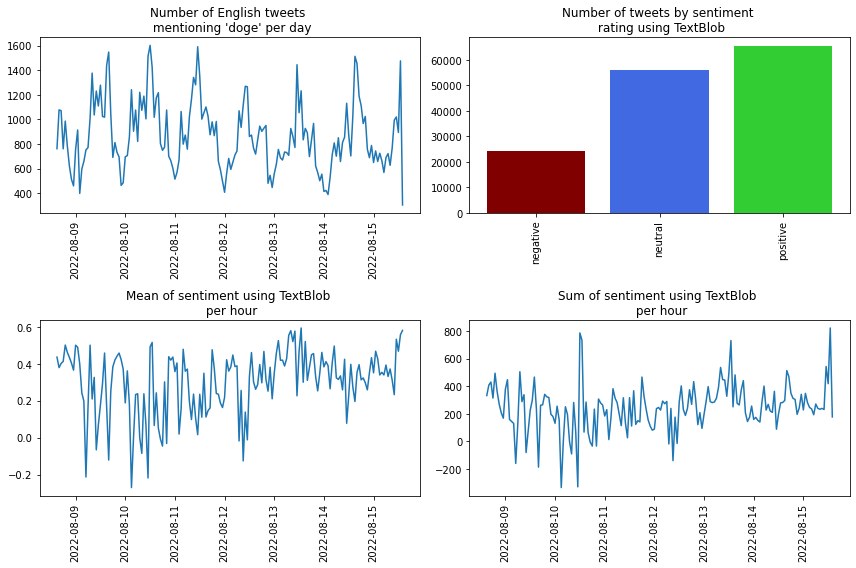

In [145]:
fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=2, figsize=(12,8))

ax1[0].plot(tweets_per_hour)
ax1[0].set_title('Number of English tweets \n mentioning \'doge\' per day')
ax1[0].tick_params(axis='x',rotation=90)

ax1[1].bar(['negative', 'neutral', 'positive'], tweets_by_sentiment, color =['maroon','royalblue','limegreen'])
ax1[1].set_title('Number of tweets by sentiment \n rating using TextBlob')
ax1[1].tick_params(axis='x',rotation=90)


ax2[0].plot(mean_sentiment_per_hour)
ax2[0].set_title('Mean of sentiment using TextBlob \n per hour')
ax2[0].tick_params(axis='x',rotation=90)

ax2[1].plot(sum_sentiment_per_hour)
ax2[1].set_title('Sum of sentiment using TextBlob \n per hour')
ax2[1].tick_params(axis='x',rotation=90)


fig.tight_layout()
plt.show()

OG PLOTS

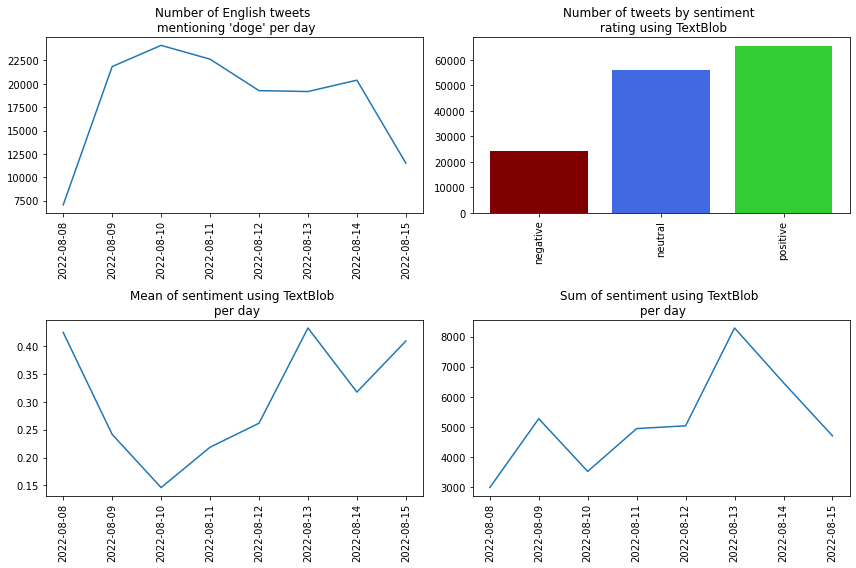

In [123]:
fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=2, figsize=(12,8))

ax1[0].plot(tweets_per_day)
ax1[0].set_title('Number of English tweets \n mentioning \'doge\' per day')
ax1[0].tick_params(axis='x',rotation=90)

ax1[1].bar(['negative', 'neutral', 'positive'], tweets_by_sentiment, color =['maroon','royalblue','limegreen'])
ax1[1].set_title('Number of tweets by sentiment \n rating using TextBlob')
ax1[1].tick_params(axis='x',rotation=90)


ax2[0].plot(mean_sentiment_per_day)
ax2[0].set_title('Mean of sentiment using TextBlob \n per day')
ax2[0].tick_params(axis='x',rotation=90)

ax2[1].plot(sum_sentiment_per_day)
ax2[1].set_title('Sum of sentiment using TextBlob \n per day')
ax2[1].tick_params(axis='x',rotation=90)



fig.tight_layout()
plt.show()

## Cleaning out bots by tweet limit

In [110]:
# Creating a series of usernames with number of tweets for each
tweets_by_user = clean_df['text'].groupby(clean_df['author_id']).count().sort_values(ascending=False)

# Defining cutoff as users with more than ten tweets per day
cutoff = [i for i in tweets_by_user[tweets_by_user<=70].index]

# Defining final DataFrame, where bots are removed
final_df = clean_df[clean_df['author_id'].isin(cutoff) == True].reset_index(drop=True)


print(f'''
Number of tweets removed: {len(clean_df)-len(final_df)} \n
Number of tweets left: {len(final_df)} \n
Percentage removed: {(len(clean_df)-len(final_df))/len(clean_df):.2f} %
''')


Number of tweets removed: 73930 

Number of tweets left: 72003 

Percentage removed: 0.51 %



### Saving to CSV for future use

In [102]:
final_df.to_csv('twitter_API_data_final.csv')